In [1]:
# importing Necessary Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import warnings

warnings.filterwarnings('ignore')

# Problem Statement

We are analyzing an open dataset from NYC TLC Trip data. We will do some EDA. After EDA, we will build some hypothesis. Then we will confirm our hypothesis using statistical methods. **We wanted to analyze what contributes to fare_amount?**

# About the dataset

The data is downloaded from NYC TLC Website(https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page). Please refer to this link for the details of metadata: https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

# Focus area

In this dataset, we will focus on following columns:
1. tpep_pickup_datetime
2. tpep_dropoff_datetime
3. Passenger_count
4. Trip_distance
5. Payment_type
6. Fare_amount

# Loading the dataset

In [3]:
df = pd.read_parquet('/kaggle/input/yellow-nyc-trip-data/yellow_tripdata_2024-01.parquet')
df.to_csv('yellow_tripdata_2024-01.csv')

In [4]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [5]:
df.shape

(2964624, 19)

In [6]:
df.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
dtype: object

As per the problem statement, there could be many factors affecting fare_amount. But we'll focus on selected few variables.

In [8]:
sample_df = df[['passenger_count', 'payment_type', 'fare_amount', 'trip_distance']]
sample_df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
sample_df['duration'] = sample_df['duration'].dt.total_seconds()/60
sample_df.head()

,passenger_count,payment_type,fare_amount,trip_distance,duration
0,1.0,2,17.7,1.72,19.800000
1,1.0,1,10.0,1.80,6.600000
2,1.0,1,23.3,4.70,17.916667
3,1.0,1,10.0,1.40,8.300000
4,1.0,1,7.9,0.80,6.100000


This will be our fundamental frame on which we will perform our analysis.

# Data Cleaning

### 1. Null Values

Finding if there are any Null values

In [9]:
sample_df.isnull().sum()

passenger_count    140162
payment_type            0
fare_amount             0
trip_distance           0
duration                0
dtype: int64

Let's see how many null records contributes in our dataframe. If null records only contribute to <= 5% of total data then we will drop null records.

In [10]:
140162/len(sample_df) * 100

4.727817085741734

Ok so it is only 4% of total dataset, we can go ahead and drop all these records.

In [11]:
sample_df.dropna(inplace = True)
sample_df

,passenger_count,payment_type,fare_amount,trip_distance,duration
0,1.0,2,17.7,1.72,19.800000
1,1.0,1,10.0,1.80,6.600000
2,1.0,1,23.3,4.70,17.916667
3,1.0,1,10.0,1.40,8.300000
4,1.0,1,7.9,0.80,6.100000
...,...,...,...,...,...
2824457,1.0,1,16.3,3.51,8.033333
2824458,1.0,1,18.4,3.36,16.516667
2824459,3.0,1,17.7,3.30,16.783333
2824460,0.0,2,5.1,0.40,3.400000


### 2. Duplicate values

We will check and clean duplicates if they exist.

In [12]:
sample_df[sample_df.duplicated()]

,passenger_count,payment_type,fare_amount,trip_distance,duration
1028,2.0,1,6.5,0.70,4.816667
2594,2.0,1,5.8,0.75,3.250000
2795,3.0,1,8.6,0.81,7.983333
2996,1.0,1,12.8,2.06,11.033333
3386,1.0,1,9.3,1.52,6.633333
...,...,...,...,...,...
2824449,1.0,1,10.0,1.28,9.033333
2824450,1.0,2,70.0,0.00,0.116667
2824452,1.0,1,19.1,3.50,17.300000
2824455,1.0,1,11.4,1.94,8.833333


There are lot of duplicates in the dataframe. We will simple drop these.

In [13]:
sample_df.drop_duplicates(inplace = True)
sample_df

,passenger_count,payment_type,fare_amount,trip_distance,duration
0,1.0,2,17.7,1.72,19.800000
1,1.0,1,10.0,1.80,6.600000
2,1.0,1,23.3,4.70,17.916667
3,1.0,1,10.0,1.40,8.300000
4,1.0,1,7.9,0.80,6.100000
...,...,...,...,...,...
2824456,1.0,1,31.0,7.68,14.416667
2824457,1.0,1,16.3,3.51,8.033333
2824458,1.0,1,18.4,3.36,16.516667
2824459,3.0,1,17.7,3.30,16.783333


### 3. Removing outliers

We will check if there are any outlier using boxplot and then remove them using IQR method.

But before that we need to make necessary data type updates.

In [15]:
sample_df['passenger_count'] = sample_df['passenger_count'].astype('int64')
sample_df['payment_type'] = sample_df['payment_type'].astype('int64')

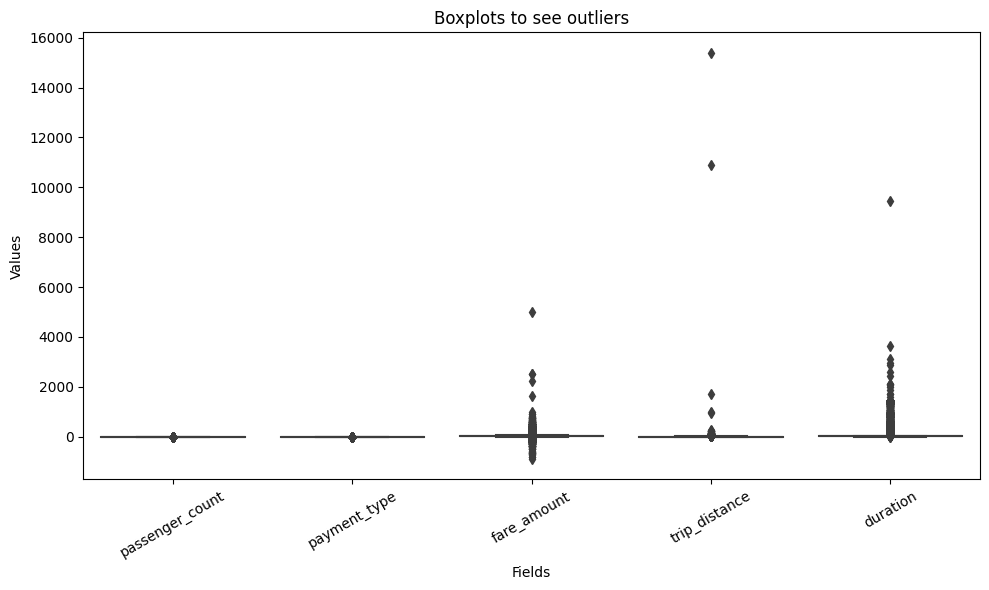

In [16]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.boxplot(data=sample_df, orient='v')  # orient='v' for vertical boxplots

plt.title('Boxplots to see outliers')  # Set the title
plt.xlabel('Fields')  # Set the x-axis label
plt.ylabel('Values')  # Set the y-axis label
plt.xticks(rotation=30)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show the plot

**Observations**:

* fare_amount have one outlier.
* trip_distance have 2 exteme outliers.
* duration have 1 outlier.
* There are some negative fare_amount as well, which is not logically possible.

Let's filter the data using IQR method

In [20]:
for col in ['fare_amount', 'trip_distance', 'duration']:
    q1 = sample_df[col].quantile(0.25) # calculating Q1
    q3 = sample_df[col].quantile(0.75) # calculating Q3
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    sample_df = sample_df[(sample_df[col] >= lower_bound) & (sample_df[col] <= upper_bound)]

Let's see visuals after removing outliers.

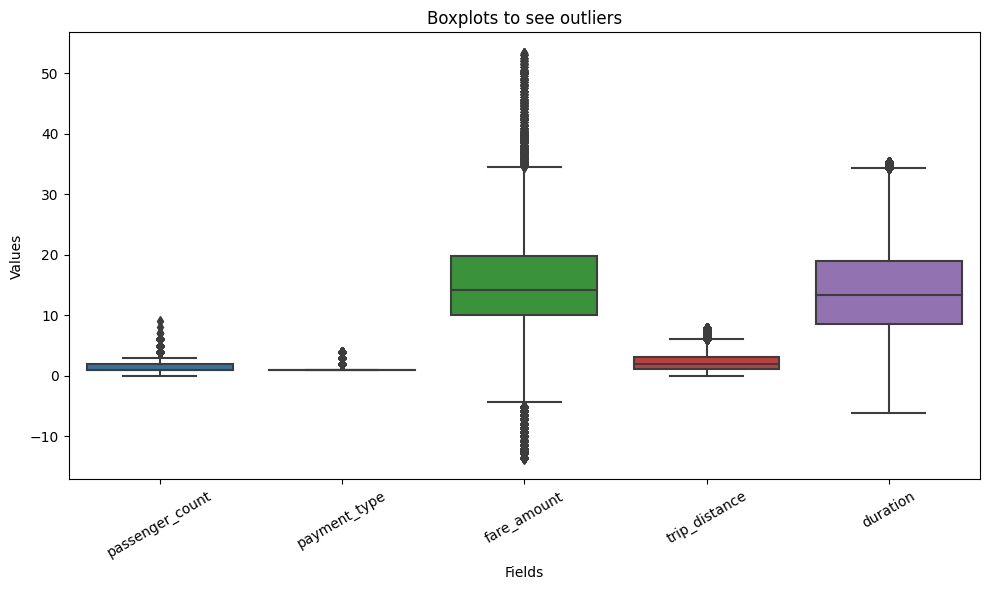

In [21]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.boxplot(data=sample_df, orient='v')  # orient='v' for vertical boxplots

plt.title('Boxplots to see outliers')  # Set the title
plt.xlabel('Fields')  # Set the x-axis label
plt.ylabel('Values')  # Set the y-axis label
plt.xticks(rotation=30)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show the plot

A better visual but still duration and fare_amount have negative values. This bring us to last step of our data cleaning process.

### 4. Removing contextual outliers

In this step we will remove datapoints that are insignificant or out of the context.

In [25]:
sample_df['passenger_count'].value_counts(normalize = True).sort_index() *100

passenger_count
0     1.745899
1    67.278851
2    18.951136
3     5.305256
4     3.072383
5     2.171259
6     1.474765
7     0.000301
8     0.000075
9     0.000075
Name: proportion, dtype: float64

As we can see in above frequency distribution:

1. passenger_count = 0 is contextual outlier
2. Only Passenger_count 1 to 5 hold significant number of records.

In [26]:
sample_df['payment_type'].value_counts(normalize = True).sort_index() * 100

payment_type
1    75.072768
2    21.663084
3     0.954237
4     2.309910
Name: proportion, dtype: float64

Since majority of the data is present in payment_type 1 and 2, we will filter only those records.

Also during the outlier analysis we found that there are negative value records in fare amount and duration. These will affect our analysis.

We will filter that as well.

In [27]:
sample_df = sample_df[sample_df['payment_type'] < 3]
sample_df = sample_df[(sample_df['passenger_count'] > 0) & (sample_df['passenger_count'] < 6)]
sample_df = sample_df[(sample_df['fare_amount'] > 0)]
sample_df = sample_df[(sample_df['duration'] > 0)]
sample_df

,passenger_count,payment_type,fare_amount,trip_distance,duration
0,1,2,17.7,1.72,19.800000
1,1,1,10.0,1.80,6.600000
2,1,1,23.3,4.70,17.916667
3,1,1,10.0,1.40,8.300000
4,1,1,7.9,0.80,6.100000
...,...,...,...,...,...
2824456,1,1,31.0,7.68,14.416667
2824457,1,1,16.3,3.51,8.033333
2824458,1,1,18.4,3.36,16.516667
2824459,3,1,17.7,3.30,16.783333


In [28]:
sample_df = sample_df.reset_index()
sample_df

,index,passenger_count,payment_type,fare_amount,trip_distance,duration
0,0,1,2,17.7,1.72,19.800000
1,1,1,1,10.0,1.80,6.600000
2,2,1,1,23.3,4.70,17.916667
3,3,1,1,10.0,1.40,8.300000
4,4,1,1,7.9,0.80,6.100000
...,...,...,...,...,...,...
1239173,2824456,1,1,31.0,7.68,14.416667
1239174,2824457,1,1,16.3,3.51,8.033333
1239175,2824458,1,1,18.4,3.36,16.516667
1239176,2824459,3,1,17.7,3.30,16.783333


### 4. Data Transformation

We will encode payment_type as Card or Cash. 

In [29]:
sample_df['payment_type'].replace([1,2],['Card','Cash'], inplace = True)

In [30]:
sample_df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,1239178.0,1.214931e+06,824362.004248,0.000000,471366.500000,1114731.50,1.905001e+06,2.824461e+06
passenger_count,1239178.0,1.497180e+00,0.910877,1.000000,1.000000,1.00,2.000000e+00,5.000000e+00
fare_amount,1239178.0,1.591242e+01,7.112771,0.010000,10.700000,14.90,2.050000e+01,5.335000e+01
trip_distance,1239178.0,2.427655e+00,1.620509,0.000000,1.230000,2.03,3.200000e+00,7.830000e+00
duration,1239178.0,1.446836e+01,7.206442,0.016667,8.983333,13.70,1.916667e+01,3.531667e+01


# Exploratory Data Analysis

### 1. Distribution of Payment modes

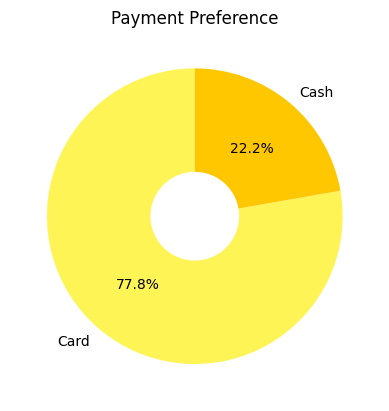

In [34]:
plt.title('Payment Preference')
plt.pie(sample_df['payment_type'].value_counts(normalize = True), labels = sample_df['payment_type'].value_counts().index,
       startangle=90, autopct = '%1.1f%%', colors = ['#FFF455', '#FFC700'])

centre_circle = plt.Circle((0,0),0.30,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.show()

### 2. Relation between Payment mode with other variables

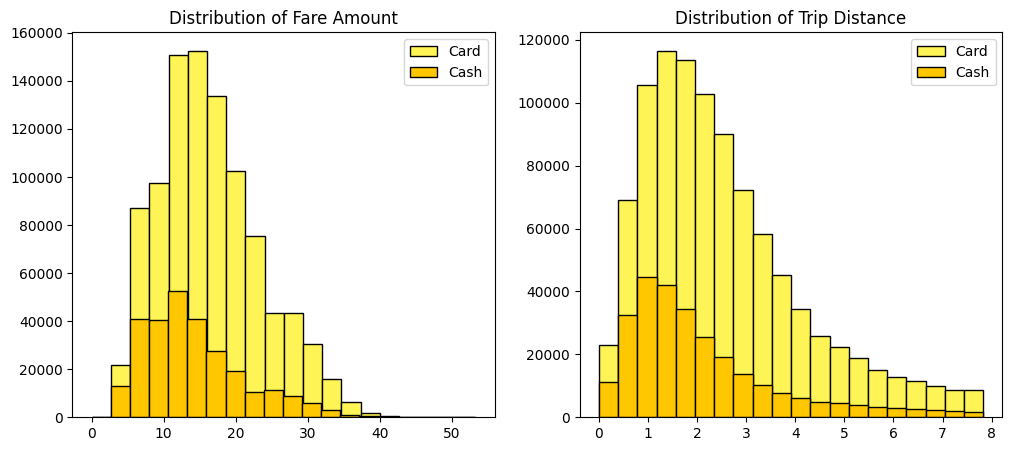

In [33]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)

plt.title('Distribution of Fare Amount')
plt.hist(sample_df[sample_df['payment_type']=='Card']['fare_amount'], histtype='barstacked', bins = 20, edgecolor = 'k', color = '#FFF455', label = 'Card')
plt.hist(sample_df[sample_df['payment_type']=='Cash']['fare_amount'], histtype='barstacked', bins = 20, edgecolor = 'k', color = '#FFC700', label = 'Cash')

plt.legend()
plt.subplot(1,2,2)

plt.title('Distribution of Trip Distance')
plt.hist(sample_df[sample_df['payment_type']=='Card']['trip_distance'], histtype='barstacked', bins = 20, edgecolor = 'k', color = '#FFF455', label = 'Card')
plt.hist(sample_df[sample_df['payment_type']=='Cash']['trip_distance'], histtype='barstacked', bins = 20, edgecolor = 'k', color = '#FFC700', label = 'Cash')

plt.legend()
plt.show()

From above plot it seems there is strong association between payment_type and fare_amount.

In [36]:
sample_df.groupby('payment_type').agg({'fare_amount':'mean', 'trip_distance':'mean'})

,fare_amount,trip_distance
payment_type,,
Card,16.41933,2.523136
Cash,14.13992,2.093791


Both trip distance and fare amount is shwing this association and we can see average fare and distance is both more for Card payment type. Let's see if this association is statistically significant.

# Statistical Inference

As we observed that previous visualizations showed significant association between fare_amount and payment_type. Let's check if our Hypothesis is statistically significant.

* **Null Hypothesis(H0):** fare_amount does not vary basis mode of payment.
* **Alternate Hypothesis(Ha):** fare_amount vary basis of mode of payment.

But first we must check if fare_amount is normally distributed or not?
Will use qq plot for same.

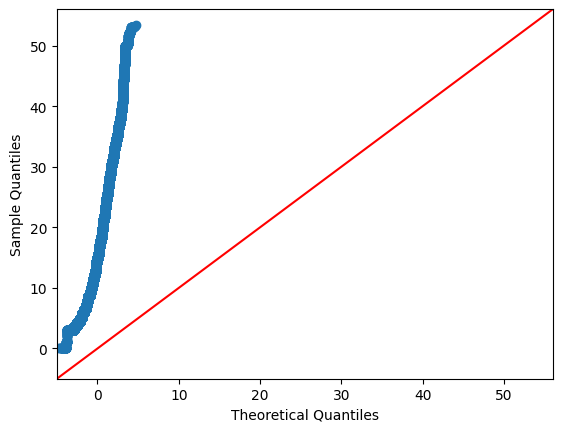

In [37]:
import statsmodels.api as sm

sm.qqplot(sample_df['fare_amount'], line = '45')
plt.show()

As we can see sample quantiles and theorotical quantiles are not aligned and hence fare_amount is not normally distributed.

In [38]:
card_sample = sample_df[sample_df['payment_type'] == 'Card']['fare_amount']
cash_sample = sample_df[sample_df['payment_type'] == 'Cash']['fare_amount']


t, p_val = st.ttest_ind(a = card_sample, b = cash_sample, equal_var= False)
# print(f't-stat: {t}, p-val: {p_val}')
print(t, p_val)
if p_val < 0.05:
    print('Reject H0')
else:
    print('Fail to Reject H0')

152.2613020982952 0.0
Reject H0


As we can see, since P-value is less than significance value, we will Reject Null Hypothesis.